In [1]:
# --------------------------------------------------------------------------------------
#                        SPICE REMOVE CONTAMINATION SCRIPT
#               Removes anomalies and outliers from the error-free CFA data
#
#    - Reads CFA dataframe (with mechanical errors removed)
#    - Calculates CPP and particle concentration (bins 1.1-10) for the full core
#    - Counts and NaNs all rows with a 'hump-shaped' PSD anomaly
#    - Creates MAD outlier removal scenarios
#    - Removes integral outliers (after Aaron)
#    - Preserves known dust events during 'hump' and outlier removal
#
#    - Loads raw, unfiltered CFA with depth corrections. Gets CPP and particle conc.
#    - Creates a series of plots to evaluate different outlier removal scenarios
#    - Creates before & after plots for the data processing
#
# Katie Anderson, 8/1/19
# ---------------------------------------------------------------------------------------

In [17]:
from   scipy.io import loadmat
import numpy  as np
from numpy import trapz
import pandas as pd
import csv
import os
from   datetime import date
import matplotlib.pyplot as plt
import statistics

# Go into the correct directory- this is a personal desktop folder that backs up to OneDrive
os.chdir('C:\\Users\\katie\\OneDrive\\Documents\\SPICE\\Scripts')

# Run mechanical error cleaning script. Can run all 3 scripts from one location here when this is finished.
#%run "Phase 1 SPICE Error Removal.ipynb"

# Run function definitions script
%run "SPICE Data Processing Functions.ipynb"

In [22]:
# ----------------------------------------------------------------------------
#                               CFA FILE PREP
#               Load Phase 1 data, Get Dust & Volcanic Events
# ----------------------------------------------------------------------------
# Load complete CFA file after mechanical error removal (-2/+6 yr volcanic buffer)
cfa = pd.read_csv('../Data/Cleaned_CFA_Phase1_2019-07-24.csv', header = 0)

# This version has only a +/- 2 year buffer around volcanic events
#cfa = pd.read_csv('../Data/Cleaned_CFA_Phase1_2019-07-19.csv', header = 0) 
del cfa['Unnamed: 0']

# Load depths of real dust events
dust_events = pd.read_excel('../Data/Dust Events.xlsx')
# Only keep the columns with the depth ranges
dust_events = dust_events.loc[:, 'Dust Event Start (m)':'Dust Event End (m)'].copy()

# Label all rows during known dust events
# Add Y/N 'Dust Event?' column. Default to false.
cfa['Dust Event?'] = False
# Get the row indices of all measurements within dust events
dust_rows = label_dust_events(cfa, dust_events)
# Change all 'Dust Event?' values in those rows to True
cfa.loc[dust_rows, 'Dust Event?'] = True

# Get the row indices of all measurements within volcanic events
volc_rows = cfa[(cfa['Volcanic Event?'] == True)].index.values.tolist()

# Get particle concentrations
# Change this if we decide to include smallest & largest bins
sum_columns = ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', 
               '1.9', '2', '2.1', '2.2', '2.3', '2.4', '2.5', '2.7', '2.9',
               '3.2', '3.6', '4', '4.5', '5.1', '5.7', '6.4', '7.2', '8.1', 
               '9', '10']
# Set skipna to False, otherwise, rows with all NaNs will sum to 0
cfa['Sum 1.1-10'] = cfa[sum_columns].sum(axis = 1, skipna = False)

# Add CPP column to CFA dataframe. Function will ask to include/exclude bins 1 and 12
cfa['CPP'] = find_cpp(cfa)

-->Use smallest and largest bins for CPP? Enter Y or N: n


In [23]:
# ----------------------------------------------------------------------------
#                                        PART 2:
#                        CFA DATA OUTLIER & CONTAMINATION REMOVAL
# ----------------------------------------------------------------------------

original_length = 438211 # From the last script
print('CFA dataset length after error removal:', original_length)
print('\n')

# 1) Identify and remove hump-shaped PSD anomalies

# Find humps for all CFA depths
humps = find_humps(cfa, 0, 1752)

# PRESERVE KNOWN DUST EVENTS
# Remove all rows in real dust events from the hump list
bad_rows = humps.index.difference(dust_rows)
# Remove all rows in real volcanic events from the hump list
bad_rows = humps.index.difference(volc_rows)

# NaN values in remaining rows, except boolean columns
cfa.loc[bad_rows, 'Depth (m)': '12'] = np.nan
cfa.loc[bad_rows, 'Age b 1950'] = np.nan
cfa.loc[bad_rows, 'CPP']        = np.nan

# Print number of measurements removed
print('\nHump measurements removed: ', len(bad_rows))
# Update dataset length
original_length = original_length - len(bad_rows)

CFA dataset length after error removal: 438211


Print detailed hump anomaly counts? Enter Y or N: n

Hump measurements removed:  2213


In [24]:
# 2) Identify and remove particle concentration & CPP outliers, using MAD

# Set # of measurements to use for background medians
window = 500
# Set threshold for accepted Median Absolute Deviations (MAD).
threshold = 2
# Make a new copy of the CFA data to ensure that the data cleaning doesn't change original data
new_cfa = cfa.copy()

# Remove overlapping concentration & CPP outliers
# Inputs: CFA data, dust event indices, volcanic event indices, background window, and MAD threshold
new_cfa, num_outliers = remove_outliers_MAD(new_cfa, dust_rows, volc_rows, window, threshold)

print('\nMAD outliers removed: ', num_outliers)


Removing MAD outliers

-->Remove outliers at volcanic events? Enter Y or N: n

-->Print results? Enter Y or N: n

MAD outliers removed:  4268


In [25]:
# 3) Identify and remove particle concentration & CPP outliers, using 2-pt. integrals

bad_rows = remove_outliers_integrals(new_cfa, 2, dust_rows, volc_rows)

# NaN values in remaining rows, except boolean columns
new_cfa.loc[bad_rows, 'Depth (m)':'12']   = np.nan
new_cfa.loc[bad_rows, 'Age b 1950']       = np.nan
new_cfa.loc[bad_rows, 'Sum 1.1-10':'CPP'] = np.nan

print('\nIntegral outliers removed:', len(bad_rows))

Removing integral outliers
Integral outliers removed: 27


In [27]:
# 4) Compute summary statistics and export data

print('Final CFA dataset length:', original_length - num_outliers - len(bad_rows))

print('\nPhase 1 Cleaning Results:')
summary_statistics(cfa)
print('\nPhase 2 Cleaning Results:')
summary_statistics(new_cfa)

#cfa.to_csv('../Data/Cleaned_CFA_Phase2_' + str(date.today()) + '.csv')

Final CFA dataset length: 431703

Phase 1 Cleaning Results:
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8817.38
    Median: 1224.96
    Min:    0.00
    Max:    39945496.23
    StDev:  79983.80
    MAD:    1.06

Coarse Particles (%):
    Mean:   4.35
    Median: 2.82
    Min:    0.00
    Max:    100.00
    StDev:  5.29
    MAD:    1.06

Phase 2 Cleaning Results:
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8591.12
    Median: 1188.25
    Min:    0.00
    Max:    39945496.23
    StDev:  79631.70
    MAD:    1.02

Coarse Particles (%):
    Mean:   4.21
    Median: 2.81
    Min:    0.00
    Max:    100.00
    StDev:  5.04
    MAD:    1.04


In [109]:
# EVERYTHING BELOW IS WORK SPACE

In [3]:
# ----------ORIGINAL CFA DATA PREP--------------------------#
# THIS IS ONLY FOR MAKING BEFORE/AFTER PLOTS

# Get concentrations and CPP (before filtering) for plotting

# Load Matlab raw, unfiltered, depth-corrected CFA file
mat = loadmat('../Data/CFA_Unfiltered_Synchronized.mat')
# Import main variable from Matlab file
mdata = mat['FinalCFA']
# Create dataframe and add 1st column
original_cfa = pd.DataFrame({'Depth (m)':mdata[:,0]})
# Add remaining columns and data to the dataframe
original_cfa['Flow Rate'] = mdata[:,1]
original_cfa['ECM'] = mdata[:,2]
original_cfa['1']   = mdata[:,3]
original_cfa['1.1'] = mdata[:,4]
original_cfa['1.2'] = mdata[:,5]
original_cfa['1.3'] = mdata[:,6]
original_cfa['1.4'] = mdata[:,7]
original_cfa['1.5'] = mdata[:,8]
original_cfa['1.6'] = mdata[:,9]
original_cfa['1.7'] = mdata[:,10]
original_cfa['1.8'] = mdata[:,11]
original_cfa['1.9'] = mdata[:,12]
original_cfa['2']   = mdata[:,13]
original_cfa['2.1'] = mdata[:,14]
original_cfa['2.2'] = mdata[:,15]
original_cfa['2.3'] = mdata[:,16]
original_cfa['2.4'] = mdata[:,17]
original_cfa['2.5'] = mdata[:,18]
original_cfa['2.7'] = mdata[:,19]
original_cfa['2.9'] = mdata[:,20]
original_cfa['3.2'] = mdata[:,21]
original_cfa['3.6'] = mdata[:,22]
original_cfa['4']   = mdata[:,23]
original_cfa['4.5'] = mdata[:,24]
original_cfa['5.1'] = mdata[:,25]
original_cfa['5.7'] = mdata[:,26]
original_cfa['6.4'] = mdata[:,27]
original_cfa['7.2'] = mdata[:,28]
original_cfa['8.1'] = mdata[:,29]
original_cfa['9']   = mdata[:,30]
original_cfa['10']  = mdata[:,31]
original_cfa['12']  = mdata[:,32]
original_cfa['Raw Depth'] = mdata[:,33]

# Get original particle concentrations for plotting later
sum_columns = ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', 
               '1.9', '2', '2.1', '2.2', '2.3', '2.4', '2.5', '2.7', '2.9',
               '3.2', '3.6', '4', '4.5', '5.1', '5.7', '6.4', '7.2', '8.1', 
               '9', '10']
original_cfa['Sum 1.1-10'] = original_cfa[sum_columns].sum(axis = 1, skipna = False)

# Get original CPP for plotting later
original_cfa['CPP'] = find_cpp(original_cfa)

-->Use smallest and largest bins for CPP? Enter Y or N: n
CPP function found negative sum of all particles.
CPP function found negative sum of coarse particles.


In [61]:
# Comparing different outlier I.D functions

window = 500
threshold = 2
# Need to make a copy to ensure that the scenario doesn't change original data
#testcfa  = cfa.copy()
testcfa2 = cfa.copy()
testcfa3 = cfa.copy()

# Original outlier removal function
#scenario = test_threshold_old(testcfa, dust_rows, window, stdev)
# Updated outlier removal function
scenario2 = test_threshold_stdev(testcfa2, dust_rows, window, threshold)
# V3
scenario3, num_outliers = remove_outliers_MAD(testcfa3, dust_rows, volc_rows, window, threshold)


NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: n

-->Remove outliers at volcanic events? Enter Y or N: n

NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: n

-->Remove outliers at volcanic events? Enter Y or N: n


In [65]:
# Print summary statistics before & after phase 1 cleaning
print('--CFA data after error removal--')
summary_statistics(cfa)
#print('\n--CFA data after original outlier removal--')
#summary_statistics(scenario)
print('\n--CFA data after st dev from mean removal--')
summary_statistics(scenario2)
print('\n--CFA data after MAD outler removal--')
summary_statistics(scenario3)

--CFA data after error removal--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8817.28
    Median: 1225.00
    Min:    0.00
    Max:    39945496.23
    StDev:  79982.58

Coarse Particles (%):
    Mean:   4.35
    Median: 2.82
    Min:    0.00
    Max:    100.00
    StDev:  5.29

--CFA data after st dev from mean removal--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8629.47
    Median: 1216.25
    Min:    0.00
    Max:    39945496.23
    StDev:  78495.85

Coarse Particles (%):
    Mean:   4.31
    Median: 2.82
    Min:    0.00
    Max:    100.00
    StDev:  5.21

--CFA data after MAD outler removal--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8590.77
    Median: 1188.40
    Min:    0.00
    Max:    39945496.23
    StDev:  79628.45

Coarse Particles (%):
    Mean:   4.21
    Median: 2.81
    Min:    0.00
    Max:    100.00
    StDev:  5.04


In [13]:
# Comparing different outlier I.D functions
# Window of 500 seems to do the best job. Not a lot of difference between different windows, except for at large events.

threshold = 2
# Need to make a copy to ensure that the scenario doesn't change original data
testcfa  = cfa.copy()
testcfa2 = cfa.copy()
testcfa3 = cfa.copy()
testcfa4 = cfa.copy()

# Testing different backgrounds
window50, num_outliers = remove_outliers_MAD(testcfa, dust_rows, volc_rows, 50, threshold)
window100, num_outliers = remove_outliers_MAD(testcfa2, dust_rows, volc_rows, 100, threshold)
window500, num_outliers = remove_outliers_MAD(testcfa3, dust_rows, volc_rows, 500, threshold)
window1000, num_outliers = remove_outliers_MAD(testcfa4, dust_rows, volc_rows, 1000, threshold)


NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: n

-->Remove outliers at volcanic events? Enter Y or N: n

NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: n

-->Remove outliers at volcanic events? Enter Y or N: n

NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: n

-->Remove outliers at volcanic events? Enter Y or N: n

NEW OUTLIER REMOVAL SCENARIO

-->Print outlier counts? Enter Y or N: n

-->Remove outliers at volcanic events? Enter Y or N: n


In [14]:
print('\n--CFA data after error removal--')
summary_statistics(cfa)
# Print summary statistics for different windows
print('\n--Window50--')
summary_statistics(window50)
print('\n--Window100--')
summary_statistics(window100)
print('\n--Window500--')
summary_statistics(window500)
print('\n--Window1000--')
summary_statistics(window1000)


--CFA data after error removal--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8817.28
    Median: 1225.00
    Min:    0.00
    Max:    39945496.23
    StDev:  79982.58

Coarse Particles (%):
    Mean:   4.35
    Median: 2.82
    Min:    0.00
    Max:    100.00
    StDev:  5.29

--Window50--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8599.69
    Median: 1197.55
    Min:    0.00
    Max:    39945496.23
    StDev:  79534.53

Coarse Particles (%):
    Mean:   4.25
    Median: 2.81
    Min:    0.00
    Max:    100.00
    StDev:  5.12

--Window100--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8593.58
    Median: 1194.07
    Min:    0.00
    Max:    39945496.23
    StDev:  79577.64

Coarse Particles (%):
    Mean:   4.24
    Median: 2.81
    Min:    0.00
    Max:    100.00
    StDev:  5.09

--Window500--
SUMMARY STATISTICS
Dust number concentration (/mL):
    Mean:   8590.77
    Median: 1188.40
    Min:    0.00
    Max:    39945496.

In [16]:
# ----------------------------------------------------------------------------
#                               PLOTTING
# ----------------------------------------------------------------------------

# Load corrected core breaks file, for plotting
#breaks = pd.read_csv('../Data/Core Breaks Full Core.csv')

# Load final volcanic ties file, for plotting
#all_ties = pd.read_excel('../Data/Final_Ties.xlsx')

# Load complete Holocene volcanic record
volcanic_record = pd.read_excel('../Data/Volcanic Record.xlsx')

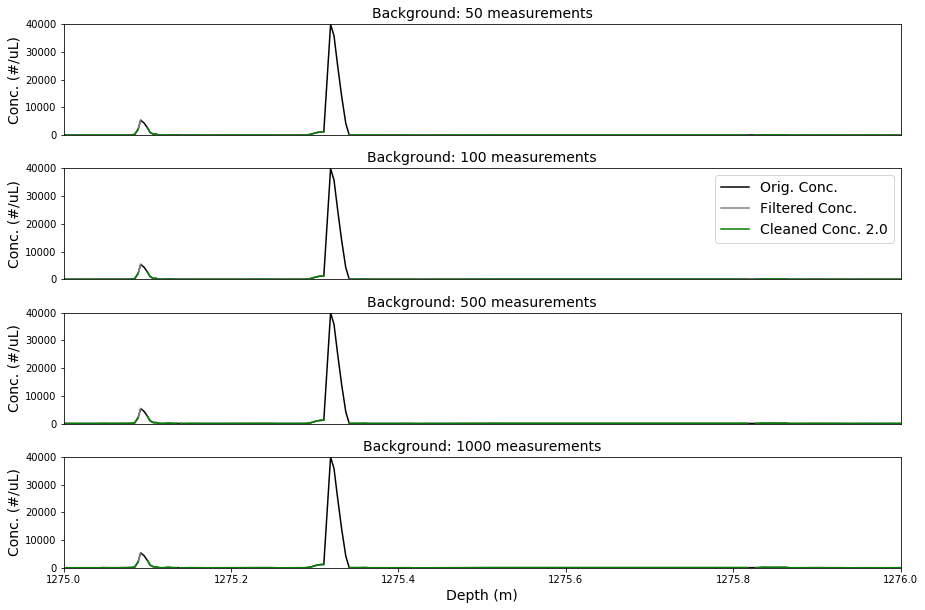

In [60]:
# PARTICLE CONCENTRATION OUTLIER REMOVAL WITH DIFFERENT WINDOWS
# BY DEPTH 

# Age 9240-9480 ~= Depth 680-690
# 975 to 995 example of good volcanic preservation
xmin = 1275
xmax = 1276
ymin = 0
ymax = 40000

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
fig.subplots_adjust(hspace = 0.3)

ax1.plot(original_cfa['Depth (m)'], original_cfa['Sum 1.1-10'], color = 'black');
ax1.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], color = 'grey');
ax1.plot(window50['Depth (m)'], window50['Sum 1.1-10'], color = 'green');    
ax1.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.set_title('Background: 50 measurements', fontsize = 14);
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(original_cfa['Depth (m)'], original_cfa['Sum 1.1-10'], color = 'black');
ax2.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], color = 'grey');
ax2.plot(window100['Depth (m)'], window100['Sum 1.1-10'], color = 'green');
#for event in volcanic_record['Start Year (b1950)']:
#    if event == np.nan or event < xmin or event > xmax: continue
#    else:
#        end = event - 6
#        start = event + 2
#        ax2.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
#        ax2.vlines(event, 0, 700000, color = 'blue')
mylabels = ['Orig. Conc.', 'Filtered Conc.', 'Cleaned Conc. 2.0', 'Volcanic Event']
ax2.legend(mylabels, fontsize = 14)
ax2.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(ymin, ymax);
ax2.set_title('Background: 100 measurements', fontsize = 14);
ax2.axes.get_xaxis().set_visible(False)

ax3.plot(original_cfa['Depth (m)'], original_cfa['Sum 1.1-10'], color = 'black');
ax3.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], color = 'grey');
ax3.plot(window500['Depth (m)'], window500['Sum 1.1-10'], color = 'green');
ax3.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax3.set_xlim(xmin, xmax);
ax3.set_ylim(ymin, ymax);
ax3.set_title('Background: 500 measurements', fontsize = 14);
ax3.axes.get_xaxis().set_visible(False)

ax4.plot(original_cfa['Depth (m)'], original_cfa['Sum 1.1-10'], color = 'black');
ax4.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], color = 'grey');
ax4.plot(window1000['Depth (m)'], window1000['Sum 1.1-10'], color = 'green');    
ax4.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax4.set_xlim(xmin, xmax);
ax4.set_ylim(ymin, ymax);
ax4.set_title('Background: 1000 measurements', fontsize = 14);
ax4.set_xlabel('Depth (m)', fontsize = 14);

#plt.savefig('../Figures/New Windows 1275-1276 m.png')

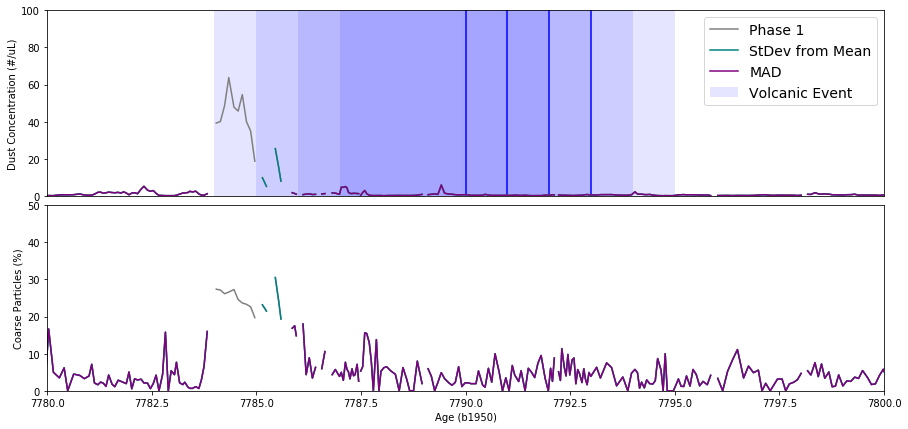

In [38]:
# BEFORE & AFTER PLOTS OF PARTICLE CONCENTRATION AND CPP, updated scenario

xmin = 7700
xmax = 7800
ymin = 0
ymax = 100

fig = plt.figure(figsize = (15,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace = 0.05)

ax1.plot(cfa['Age b 1950'], cfa['Sum 1.1-10'], c = 'grey');
ax1.plot(scenario2['Age b 1950'], scenario2['Sum 1.1-10'], color = 'teal')
ax1.plot(scenario3['Age b 1950'], scenario3['Sum 1.1-10'], color = 'purple')

for start in volcanic_record['Start Year (b1950)']:
    if start == np.nan: continue
    elif start < xmin or start > xmax: continue
    else:
        end = start - 8
        event = start - 2
        ax1.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
        ax1.vlines(event, 0, 700000, color = 'blue')
    
mylabels = ['Phase 1', 'StDev from Mean', 'MAD', 'Volcanic Event'];
ax1.legend(mylabels, fontsize = 14);
ax1.set_ylabel('Dust Concentration (#/uL)');
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(cfa['Age b 1950'], cfa['CPP'], c = 'grey');
ax2.plot(scenario2['Age b 1950'], scenario2['CPP'], color = 'teal')
ax2.plot(scenario3['Age b 1950'], scenario3['CPP'], color = 'purple')
ax2.set_ylabel('Coarse Particles (%)');
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(0,50);
ax2.set_xlabel('Age (b1950)');

#plt.savefig('../Figures/New Outliers 1233-1235.png')

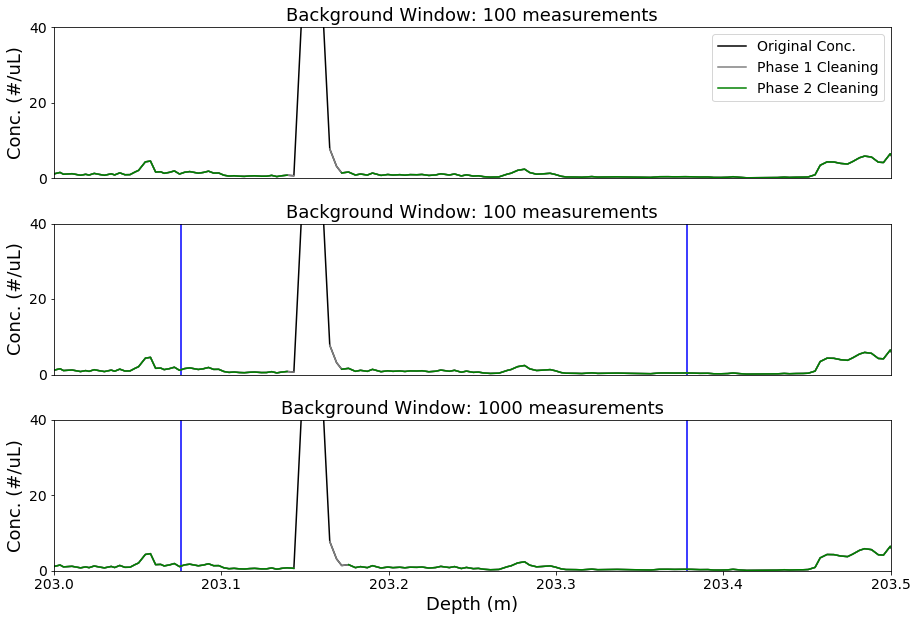

In [65]:
# PARTICLE CONCENTRATION OUTLIER REMOVAL WITH DIFFERENT BACKGROUNDS
# BY DEPTH
# 680-684 for big event
xmin = 203
xmax = 203.5
ymin = 0
ymax = 40

fig = plt.figure(figsize = (15,10));
ax1 = fig.add_subplot(311);
ax2 = fig.add_subplot(312);
ax3 = fig.add_subplot(313);
fig.subplots_adjust(hspace = 0.3)

ax1.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax1.plot(cfa_holocene['Depth (m)'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax1.plot(scenario1['Depth (m)'], scenario1['Sum 1.1-10'], color = 'green');
ax1.set_ylabel('Conc. (#/uL)', fontsize = 18);
mylabels = ['Original Conc.', 'Phase 1 Cleaning','Phase 2 Cleaning', 'Volcanic Event'];
ax1.legend(mylabels, fontsize = 14);
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.set_title('Background Window: ' + str(window1) + ' measurements', fontsize = 18);
ax1.axes.get_xaxis().set_visible(False);
ax1.set_yticks([0, 20, 40]);
ax1.tick_params(labelsize = 14);

ax2.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax2.plot(cfa_holocene['Depth (m)'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax2.plot(scenario2['Depth (m)'], scenario2['Sum 1.1-10'], color = 'green');
ax2.vlines(holocene_volc['Core Depth (m)'], 0, 700000, color = 'blue')    
ax2.set_ylabel('Conc. (#/uL)', fontsize = 18);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(ymin, ymax);
ax2.set_title('Background Window: ' + str(window2) + ' measurements', fontsize = 18);
ax2.axes.get_xaxis().set_visible(False);
ax2.set_yticks([0, 20, 40]);
ax2.tick_params(labelsize = 14);

ax3.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax3.plot(cfa_holocene['Depth (m)'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax3.plot(scenario3['Depth (m)'], scenario3['Sum 1.1-10'], color = 'green');
ax3.vlines(holocene_volc['Core Depth (m)'], 0, 700000, color = 'blue')    
ax3.set_ylabel('Conc. (#/uL)', fontsize = 18);
ax3.set_xlabel('Depth (m)', fontsize = 18);
ax3.set_xlim(xmin, xmax);
ax3.set_ylim(ymin, ymax);
ax3.set_title('Background Window: ' + str(window3) + ' measurements', fontsize = 18);
ax3.tick_params(labelsize = 14);
ax3.set_yticks([0, 20, 40]);

#plt.savefig('../Figures/682 event volcs preserved.png')

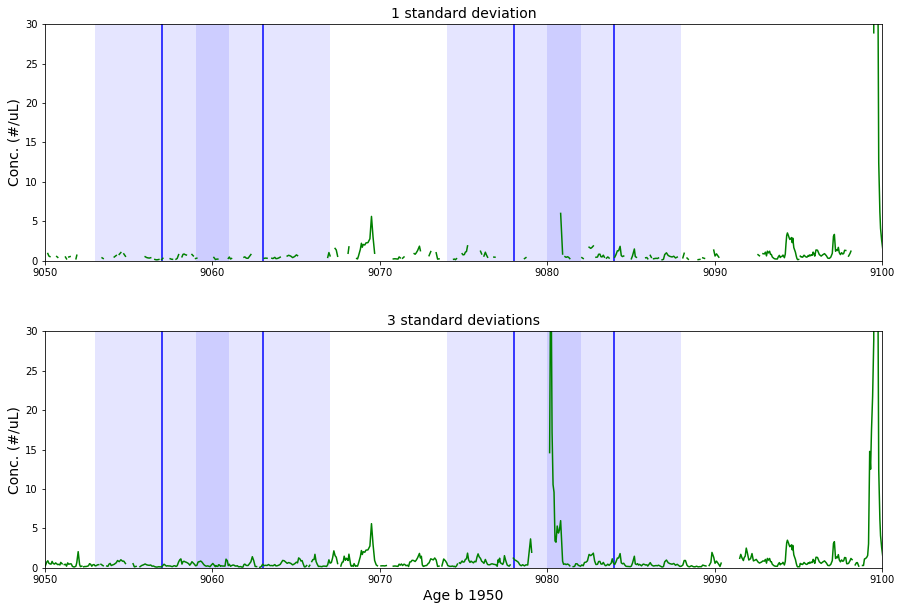

In [48]:
# PARTICLE CONCENTRATIONS W/ DIFFERENT STANDARD DEVIATION THRESHOLDS
# BY AGE

# Age 9240-9480 ~= Depth 680-690
# 975 to 995 example of good volcanic preservation

xmin = 9050
xmax = 9100
ymin = 0
ymax = 30

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace = 0.3)

#ax1.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax1.plot(scenario2['Age b 1950'], scenario2['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax1.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax1.vlines(midpoint, 0, 700000, color = 'blue')
    
ax1.set_ylabel('Conc. (#/uL)', fontsize = 14);
#mylabels = ['Filtered Conc.', 'Cleaned Conc.', 'Volcanic Event']
#ax1.legend(mylabels, fontsize = 14)
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, ymax);
ax1.set_title('1 standard deviation', fontsize = 14);

#ax2.plot(cfa_holocene['Age b 1950'], cfa_holocene['Sum 1.1-10'], color = 'grey');
ax2.plot(scenario5['Age b 1950'], scenario5['Sum 1.1-10'], color = 'green');

for start in holocene_volc['Buffered Start Year (b1950)']:
    end = start - 8
    midpoint = (start + end) / 2
    ax2.axvspan(start, end, facecolor = 'blue', alpha = 0.1)
    ax2.vlines(midpoint, 0, 700000, color = 'blue')
    
ax2.set_ylabel('Conc. (#/uL)', fontsize = 14);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(ymin, ymax);
ax2.set_xlabel('Age b 1950', fontsize = 14);
ax2.set_title('3 standard deviations', fontsize = 14);

#plt.savefig('../Figures/Min&Max2, not preserving.png')

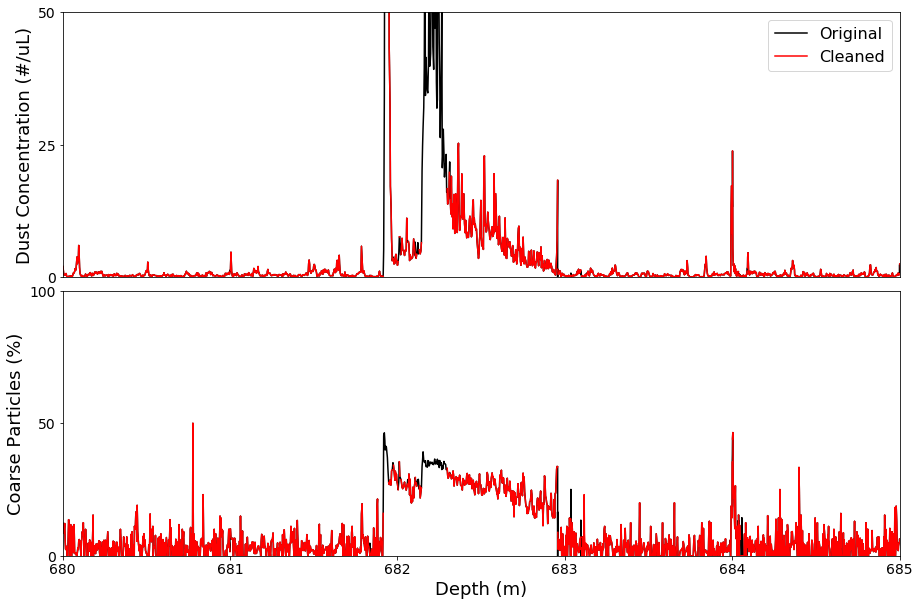

In [11]:
# BEFORE & AFTER PLOTS OF PARTICLE CONCENTRATION AND CPP

xmin = 680
xmax = 685
ymin = 0
ymax = 100

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.subplots_adjust(hspace = 0.05)


ax1.plot(original_cfa['Depth (m)'], original_cfa['Sum 1.1-10'], c = 'black');
ax1.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], color = 'red')
ax1.set_ylabel('Dust Concentration (#/uL)', fontsize = 18);
mylabels = ['Original', 'Cleaned'];
ax1.legend(mylabels, fontsize = 16);
ax1.set_xlim(xmin, xmax);
ax1.set_ylim(ymin, 50);
ax1.tick_params(labelsize = 14);
ax1.set_yticks([0, 25, 50]);
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(original_cfa['Depth (m)'], original_cfa['CPP'], c = 'black');
ax2.plot(cfa['Depth (m)'], cfa['CPP'], color = 'red')
ax2.set_ylabel('Coarse Particles (%)', fontsize = 18);
ax2.set_xlim(xmin, xmax);
ax2.set_ylim(0, 80);
ax2.tick_params(labelsize = 14);
ax2.set_yticks([0, 50, 100]);
ax2.set_xlabel('Depth (m)', fontsize = 18);

#plt.savefig('../Figures/682-683 for proposal.png')

In [ ]:
# BEFORE & AFTER CONCENTRATION & CPP PLOTS, WITH STANDARD DEVIATIONS, TIE POINTS, & CORE BREAKS

#Before & after conc. & cpp plots

# Choose interval of interest
xmin = 240
#xmax = xmin + 2
xmax = 242
label = xmin

fig = plt.figure(figsize = (15,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(original_cfa['Depth (m)'], original_sums, c = 'black');
ax1.plot(original_cfa['Depth (m)'], original_sums.rolling(100).std(), c = 'red')
# To plot volcanic ties (bottom depths)
ax1.vlines(all_ties['Bot D (m)'], 0, 700000, color = 'blue')
# To plot core break ranges
ax1.vlines(breaks['3 cm Range (m)'], 0, 700000, color = 'grey')
mylabels = ['Conc.', 'St. Dev','Tie Points','Core Break Ranges']
ax1.legend(labels = mylabels)
ax1.set_ylabel('Original Conc. (# / uL)', fontsize = 12);
ax1.set_ylim(0, 20);
ax1.set_yticks([0, 10, 20]);
ax1.set_xlim(xmin,xmax);

ax2.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'], c = 'black');
ax2.plot(cfa['Depth (m)'], cfa['Sum 1.1-10'].rolling(100).std(), c = 'red');
# To plot volcanic ties (bottom depths)
ax2.vlines(all_ties['Bot D (m)'], 0, 700000, color = 'blue')
# To plot core break ranges
ax2.vlines(breaks['3 cm Range (m)'], 0, 700000, color = 'grey')
ax2.set_ylabel('New Conc. (# / uL)', fontsize = 12);
ax2.set_ylim(0, 20);
ax2.set_yticks([0, 10, 20])
ax2.set_xlim(xmin,xmax);
ax2.axes.get_xaxis().set_visible(False);

ax3.plot(original_cfa['Depth (m)'], original_cfa['CPP'], c = 'black');
ax3.plot(original_cfa['Depth (m)'], original_cfa['CPP'].rolling(100).std(), c = 'green')
ax3.set_ylabel('Original CPP (%)', fontsize = 12);
ax3.set_ylim(0, 40);
ax3.set_xlim(xmin,xmax);
ax3.set_yticks([0, 20, 40])
ax3.axes.get_xaxis().set_visible(False);

ax4.plot(cfa['Depth (m)'], cfa['CPP'], c = 'black');
ax4.plot(cfa['Depth (m)'], cfa['CPP'].rolling(100).std(), c = 'green');
ax4.set_ylabel('New CPP (%)', fontsize = 12);
ax4.set_ylim(0, 40)
ax4.set_yticks([0, 20, 40])
ax4.set_xlim(xmin,xmax);
ax4.set_xlabel('Depth (m)', fontsize = 12);

#plt.savefig('../Figures/Cleaned_' + str(label) + '.png')

In [109]:
# WHY ARE THESE ZEROES HERE IN THE RAW, UNFILTERED DATA?
# MY RAW_CFA FILE IS THE SAME. ARE THESE ZEROES REAL?
# Happens right at 20,000 years ago
# Melt issues here in melt log. What to do when system crashed, or Abakus wasn't working?
# Why did phase 1 remove these data? Did it actually?

original_cfa.loc[286510:286520, :]

,Depth (m),Flow Rate,ECM,1,1.1,1.2,1.3,1.4,1.5,1.6,...,5.1,5.7,6.4,7.2,8.1,9,10,12,Original Depth (m),CPP
286510,1081.721263,2150.0,2.25,5.581395,2.790698,1.364341,0.868217,0.682171,0.558140,0.589147,...,0.049612,0.021705,0.006202,0.000000,0.000000,0.000000,0.0,0.0,1081.7110,1.445466
286511,1081.724255,1589.0,2.33,23.285085,11.327879,5.726872,3.775960,2.706104,2.517307,2.454374,...,0.327250,0.113279,0.062933,0.012587,0.006293,0.000000,0.0,0.0,1081.7140,2.272445
286512,1081.727247,2237.8,2.35,20.718400,10.562322,5.321785,3.981183,2.924951,2.518708,2.274962,...,0.341244,0.138123,0.032499,0.008125,0.000000,0.012187,0.0,0.0,1081.7170,2.354178
286513,1088.126501,-40.6,0.05,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,1088.1350,NaN
286514,1088.129594,3248.6,1.70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1381,NaN
286515,1088.132586,2543.8,1.78,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1411,NaN
286516,1088.135679,2421.2,1.85,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1442,NaN
286517,1088.138671,2746.2,2.19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1472,NaN
286518,1088.141764,2115.8,2.17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1503,NaN
286519,1088.144756,2286.0,2.08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1088.1533,NaN


In [25]:
cfa.loc[286510:286520, 'Depth (m)':'1.2']

,Depth (m),Flow Rate,ECM,1,1.1,1.2
286510,1081.721263,2150.0,2.25,5.581395,2.790698,1.364341
286511,1081.724255,1589.0,2.33,23.285085,11.327879,5.726872
286512,1081.727247,2237.8,2.35,20.718400,10.562322,5.321785
286513,NaN,NaN,NaN,NaN,NaN,NaN
286514,1088.129594,3248.6,1.70,0.000000,0.000000,0.000000
286515,1088.132586,2543.8,1.78,0.000000,0.000000,0.000000
286516,1088.135679,2421.2,1.85,0.000000,0.000000,0.000000
286517,1088.138671,2746.2,2.19,0.000000,0.000000,0.000000
286518,1088.141764,2115.8,2.17,0.000000,0.000000,0.000000
286519,1088.144756,2286.0,2.08,0.000000,0.000000,0.000000


In [39]:
cfa.loc[287050:287052, 'Depth (m)':'1.2']

,Depth (m),Flow Rate,ECM,1,1.1,1.2
287050,1090.227274,2482.6,3.38,0.00000,0.00000,0.000000
287051,1090.229271,2261.2,2.83,0.00000,0.00000,0.000000
287052,1090.232366,2671.6,2.54,25.20806,11.24082,5.307913


In [38]:
# Adding mode in here
modes = cfa.loc[:, '1.1':'10'].idxmax(axis = 1).astype(float)

<class 'pandas.core.series.Series'>


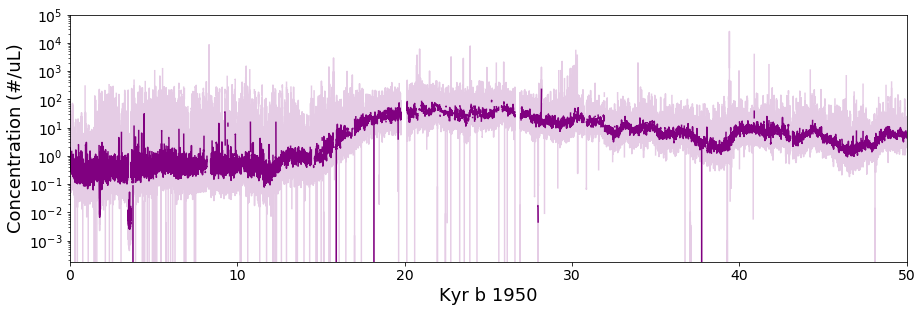

In [7]:
# Final conc. dataset
xmin = 0
xmax = 50

age_kyr = cfa['Age b 1950'].div(1000)
running_med_conc = cfa['Sum 1.1-10'].rolling(50).median()
running_med_cpp  = cfa['CPP'].rolling(50).median()

fig = plt.figure(figsize = (15,10));
ax1 = fig.add_subplot(211);
#ax2 = fig.add_subplot(212);
#fig.subplots_adjust(hspace = 0.1);

ax1.plot(age_kyr, cfa['Sum 1.1-10'], c = 'purple', alpha = 0.2);
ax1.plot(age_kyr, running_med_conc, c = 'purple')
ax1.set_xlim(xmin, xmax);
ax1.tick_params(labelsize = 14);
#ax1.set_yticks([0, 5000, 10000]);
#ax1.set_ylim(0, 100)
ax1.set_yscale("log")
ax1.set_ylabel('Concentration (#/uL)', fontsize = 18);
#ax1.axes.get_xaxis().set_visible(False);
ax1.set_xlabel('Kyr b 1950', fontsize = 18);

#ax2.plot(age_kyr, cfa['CPP'], c = 'purple', alpha = 0.2);
#ax2.plot(age_kyr, running_med_cpp, c = 'purple')
#ax2.set_ylabel('Coarse Particles (%)', fontsize = 18);

#ax2.plot(age_kyr, modes, c = 'purple')
#ax2.set_ylabel('Modal Size (um)', fontsize = 18)

#ax2.set_xlim(xmin, xmax);
#ax2.set_ylim(0, 10);
#ax2.tick_params(labelsize = 14);
#ax2.set_xlabel('Kyr b 1950', fontsize = 18);

#plt.savefig('../Figures/Glacial_RunningMedian_LogScale.png')